In [0]:
# Install latest version of spark. If error, check the latest and replace "spark-2.4.4"
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

import os
import findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"
findspark.init()

In [0]:
# Mount to Google drive to get data
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Import dependencies
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml.feature import *
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

In [0]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
filename = "/content/drive/My Drive/Colab Notebooks/SPARCS-2017_cleaned2.csv"
wholeData = spark.read.csv(filename, inferSchema=True, header=True).limit(1000000)

In [5]:
wholeData.cache()

DataFrame[Hospital Service Area: string, Hospital County: string, Facility Name: string, Age Group: string, Zip Code - 3 digits: string, Gender: string, Race: string, Ethnicity: string, Length of Stay: int, Type of Admission: string, Patient Disposition: string, CCS Diagnosis Description: string, CCS Procedure Description: string, APR DRG Description: string, APR MDC Description: string, APR Severity of Illness Description: string, APR Risk of Mortality: string, APR Medical Surgical Description: string, Payment Typology 1: string, Payment Typology 2: string, Payment Typology 3: string, Birth Weight: double, Emergency Department Indicator: string, Total Charges: double, Total Costs: double]

In [0]:
# split column type into categorical and numerical
categorical = ['Zip Code - 3 digits', 'Age Group', 'Gender', 'Race', 'Type of Admission']
numeric = ['Length of Stay', 'Total Charges']

In [0]:
stages = [] # stages in our Pipeline

# Category Indexing with StringIndexer and OneHotEncoding to convert into binary SparseVectors
for col in categorical:
    stringIndexer = StringIndexer(inputCol=col, outputCol=col + "Index")
    encoder = OneHotEncoderEstimator(inputCols=[col + "Index"], outputCols=[col + "classVec"])
    stages += [stringIndexer, encoder]

# Numeric columns casted from String type to Float type
for col in numeric:
    wholeData = wholeData.withColumn(col, wholeData[col].cast('float'))

In [0]:
# Create labels for training data with only 5 fields we want
trainingDataWithTarget = wholeData.withColumn("avg_charges_per_day", wholeData['Total Charges']/wholeData['Length of Stay'])\
                                  .select(['Zip Code - 3 digits', 'Age Group', 'Gender', 'Race', 'Type of Admission', 'avg_charges_per_day'])

In [9]:
trainingDataWithTarget.cache()

DataFrame[Zip Code - 3 digits: string, Age Group: string, Gender: string, Race: string, Type of Admission: string, avg_charges_per_day: double]

In [0]:
# Transform all features into a vector using VectorAssembler with 5 fields
assemblerInputs = [c + "classVec" for c in categorical]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [0]:
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(trainingDataWithTarget)
preppedDataDF = pipelineModel.transform(trainingDataWithTarget)

In [0]:
# Save the pipelineModel for customized user input
pipelineModel.save("/content/drive/My Drive/Colab Notebooks/pipelineModel-1Mdata-2")

In [12]:
preppedDataDF.select(['features', 'avg_charges_per_day']).show(1)

+--------------------+-------------------+
|            features|avg_charges_per_day|
+--------------------+-------------------+
|(63,[9,50,54,55,5...|           7314.625|
+--------------------+-------------------+
only showing top 1 row



In [0]:
# Label and training features
selectedcols = ["avg_charges_per_day", "features"]
vectorizedDataset = preppedDataDF.select(selectedcols)

In [14]:
# Utilized a lot below
vectorizedDataset.show(5)
print (type(vectorizedDataset))

+-------------------+--------------------+
|avg_charges_per_day|            features|
+-------------------+--------------------+
|           7314.625|(63,[9,50,54,55,5...|
|      6607.83984375|(63,[9,51,53,55,5...|
|    9007.7724609375|(63,[9,50,53,55,5...|
|             7633.5|(63,[9,53,55,58],...|
| 16430.026041666668|(63,[9,50,54,57,5...|
+-------------------+--------------------+
only showing top 5 rows

<class 'pyspark.sql.dataframe.DataFrame'>


In [79]:
vectorizedDataset.select('features').collect()[0]

Row(features=SparseVector(63, {9: 1.0, 50: 1.0, 54: 1.0, 55: 1.0, 58: 1.0}))

## **PySpark MLlib Decision Tree Model and RMSE**

In [0]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor

train_data, test_data = vectorizedDataset.randomSplit([0.8, 0.2])
regressor = GBTRegressor(featuresCol='features', labelCol='avg_charges_per_day', maxDepth=10, maxIter=30)

model = regressor.fit(train_data)

In [16]:
predictions = model.transform(test_data)

from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="avg_charges_per_day", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 12401.1


In [0]:
model.save("/content/drive/My Drive/Colab Notebooks/pySparkModel")

In [0]:
# Schema for 5 Fields customized test input
schema = StructType([StructField('Age Group',StringType(),True),
                     StructField('Zip Code - 3 digits',StringType(),True),
                     StructField('Gender',StringType(),True),
                     StructField('Race',StringType(),True),
                     StructField('Type of Admission',StringType(),True)])

In [0]:
# customized input data for testing
testDataWithTarget = spark.createDataFrame([Row('0 to 17','101','F','White','Emergency')], schema)

In [0]:
# reload pipelineModel
loadedModel = PipelineModel.load("/content/drive/My Drive/Colab Notebooks/pipelineModel")
testDataWithTargetDF = loadedModel.transform(testDataWithTarget)
testDataWithTargetDF.select('features').show()

+--------------------+
|            features|
+--------------------+
|(63,[47,52,53,55,...|
+--------------------+



In [0]:
# reload pySpark Model
from pyspark.ml.regression import GBTRegressionModel
testModel = GBTRegressionModel.load("/content/drive/My Drive/Colab Notebooks/pySparkModel")

In [0]:
predictions = testModel.transform(testDataWithTargetDF)

In [0]:
predictions.select('prediction').show()

+------------------+
|        prediction|
+------------------+
|12974.417774105545|
+------------------+



### **KMEANS**

In [0]:
pdf = vectorizedDataset.toPandas()
series = pdf['features'].apply(lambda x : np.array(x.toArray())).values.reshape(-1,1)
features = np.apply_along_axis(lambda x : x[0], 1, series)
labels = pdf['avg_charges_per_day'].values.reshape(-1,1)

In [0]:
np.savetxt('/content/drive/My Drive/Colab Notebooks/features.out', features, delimiter=',', fmt='%d')
np.savetxt('/content/drive/My Drive/Colab Notebooks/labels.out', labels, delimiter=',', fmt='%.3f')

In [0]:
from pyspark.mllib.clustering import KMeans, KMeansModel

f = spark.sparkContext.textFile('/content/drive/My Drive/Colab Notebooks/features.out')
rddForCluster = f.map(lambda line: np.array([__builtin__.float(x) for x in line.split(',')]))
clusters = KMeans.train(rddForCluster, 8, maxIterations=100, initializationMode='k-means||')

In [0]:
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return (__builtin__.sum([x ** 2 for x in (point - center)])) ** 0.5

In [184]:
WSSSE = rddForCluster.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

Within Set Sum of Squared Error = 13220.150763551235


In [0]:
kmeansLabels = clusters.predict(rddForCluster)
np.savetxt('/content/drive/My Drive/Colab Notebooks/kmeanslabels.out', np.array(kmeansLabels.collect()), delimiter=',', fmt='%f')

In [0]:
# TSNE for 3-dimension

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3, svd_solver='full')
embedding_reduced = pca.fit_transform(features)        

In [0]:
embedded3 = TSNE(n_components=3, perplexity=48.0, verbose=1).fit_transform(embedding_reduced)

In [0]:
np.savetxt('/content/drive/My Drive/Colab Notebooks/tsneembedded3.out', embedded3, delimiter=',', fmt='%f')

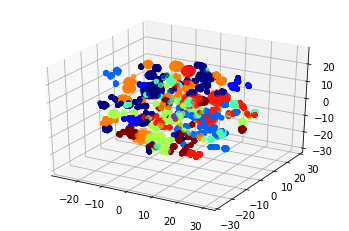

In [189]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedded3[:, 0], embedded3[:, 1], embedded3[:, 2], c=kmeansLabels.collect(), cmap=plt.cm.get_cmap("jet", 10))

### **Neural Network**

In [0]:
# Install PyTorch
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

In [19]:
pdf = vectorizedDataset.toPandas()
pdf.describe

<bound method NDFrame.describe of         avg_charges_per_day                                           features
0               7314.625000  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1               6607.839844  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2               9007.772461  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3               7633.500000  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4              16430.026042  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
...                     ...                                                ...
999995          7949.466797  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
999996          4731.475098  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
999997          7302.500000  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
999998         10376.032227  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
999999          5950.080078  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

[1000000 rows x 2

In [0]:
# pdf.to_pickle('/content/drive/My Drive/Colab Notebooks/pdf')

In [0]:
# pdf = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/pdf')
# pdf.describe

In [0]:
series = pdf['features'].apply(lambda x : np.array(x.toArray())).values.reshape(-1, 1)
features = np.apply_along_axis(lambda x : x[0], 1, series)
labels = pdf['avg_charges_per_day'].values.reshape(-1, 1)

In [0]:
import torch
pyf = torch.from_numpy(features)
pyl = torch.from_numpy(labels)
pydata = torch.cat((pyf, pyl), 1)
pydata.shape

In [0]:
# Import PyTorch model dependencies
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
dataset_size = len(pydata)
indices = list(range(dataset_size))
split = int(np.floor(.2 * dataset_size))
shuffle_dataset = True
batch_size = 32
random_seed = 1

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(pydata, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(pydata, batch_size=1, sampler=test_sampler)

In [0]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, 32)
        self.hidden2 = torch.nn.Linear(32, 16)
        self.hidden3 = torch.nn.Linear(16, 8)
        self.hidden4 = torch.nn.Linear(8, 4)
        self.predict = torch.nn.Linear(4, n_output)

    def forward(self, x):
        x = F.relu(self.hidden1(x))      
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.hidden4(x))
        x = self.predict(x)     
        return x

net = Net(n_feature=pyf.shape[1], n_output=1).float()
momentum_value = 0.0
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=momentum_value)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
# optimizer = torch.optim.Adagrad(net.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
epochs = 60

In [0]:
for epoch in range(1, epochs+1):

    running_loss = 0.0
    for batch_idx, batch_data in enumerate(train_loader, 1):
        inputs, labels = Variable(batch_data[:, :-1]).float(), Variable(batch_data[:, -1].reshape((-1, 1))).float()
    
        optimizer.zero_grad()
        outputs = net(inputs)
        
        loss = torch.sqrt(criterion(outputs, labels))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 20000 == 19999:    
            print('[%d, %5d] RMSE loss: %.3f' % (epoch, batch_idx, running_loss / 20000.0))
            running_loss = 0.0

In [32]:
total_loss = 0.0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = Variable(data[:, :-1]).float(), Variable(data[:, -1].reshape((-1, 1))).float()
        outputs = net(inputs)
        loss = torch.sqrt(criterion(outputs, labels))
        total_loss += loss

print (total_loss / len(test_loader))

tensor(9835.3730)


In [0]:
PATH = '/content/drive/My Drive/Colab Notebooks/net.pth'
torch.save(net.state_dict(), PATH)